## Load Dependancies

In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats
import statsmodels.api as sm

from sklearn.manifold import MDS
import pdb

import warnings
warnings.filterwarnings("ignore")



In [2]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
subs2analyze = sub_info[(sub_info[f'{atlas}_exclude'] != 1) & (sub_info[f'{atlas}_ts'] == 1)]
group = 'infant'

age_bins = [26,33, 38,42,46]
age_groups = ['Pre-Term','Early-Term','Term','Post-Term']



#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', '#00fd00']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




### Identify infants with poor signal

Essentially, exclude any subs who are <2 SDs below the mean of the group

In [3]:
#load noise ceiling data
noise_df = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')

#add age column
noise_df['age'] = (noise_df['scan_age'] - noise_df['birth_age'])*7

#add age group column
noise_df['age_group'] = np.nan

for i in range(len(age_bins)-1):
    noise_df.loc[(noise_df['scan_age'] >= age_bins[i]) & (noise_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['ses'].isin(subs2analyze['ses'])]


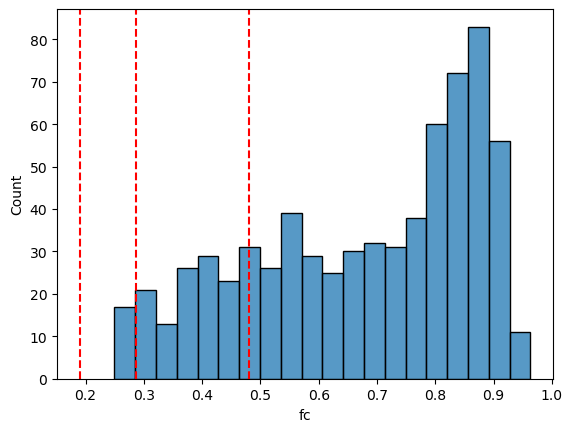

In [4]:
#compute average noise ceiling for each subject
noise_df_mean = noise_df.groupby(['sub', 'ses','age_group']).mean(numeric_only=True).reset_index()

#plot histogram of noise ceiling
plt.figure()
sns.histplot(noise_df_mean['fc'], bins=20)
#add line at SD = 1, 2
#compute SD of noise ceiling
sd = np.std(noise_df_mean['fc'])
mean = np.mean(noise_df_mean['fc'])
plt.axvline(x=mean- sd, color='r', linestyle='--')
plt.axvline(x=mean- (2*sd), color='r', linestyle='--')
plt.axvline(x=mean- (2.5*sd), color='r', linestyle='--')

In [5]:
#print how many subs are below 1, 2, 2.5 SD
print(f'Number of subs below 1 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-sd])}')
print(f'Number of subs below 2 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2*sd)])}')
print(f'Number of subs below 2.5 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2.5*sd)])}')

#print number of subs of each age group below 1, 2, 2.5 SD
for age_group in age_groups:
    print(f'Number of {age_group} subs below 2 SD: {len(noise_df_mean[(noise_df_mean["fc"] < mean-(2*sd)) & (noise_df_mean["age_group"] == age_group)])} out of {len(noise_df_mean[noise_df_mean["age_group"] == age_group])}')
    

Number of subs below 1 SD: 142
Number of subs below 2 SD: 20
Number of subs below 2.5 SD: 0
Number of Pre-Term subs below 2 SD: 0 out of 42
Number of Early-Term subs below 2 SD: 3 out of 119
Number of Term subs below 2 SD: 11 out of 350
Number of Post-Term subs below 2 SD: 6 out of 181


In [6]:
#mark subs with noise ceiling below 2 SD in sub_info sheet
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].astype(str)
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].replace('nan', '')

for sub in noise_df_mean[noise_df_mean['fc'] < mean-(2*sd)]['sub']:
    sub_info.loc[sub_info['participant_id'] == sub, f'{atlas}_exclude'] = '1'

In [8]:
#save sub_info sheet
sub_info.to_csv(f'{git_dir}/participants_dhcp.csv', index=False)

### Plot Noise ceilings for each age group

Text(0.5, 0, 'Age Group')

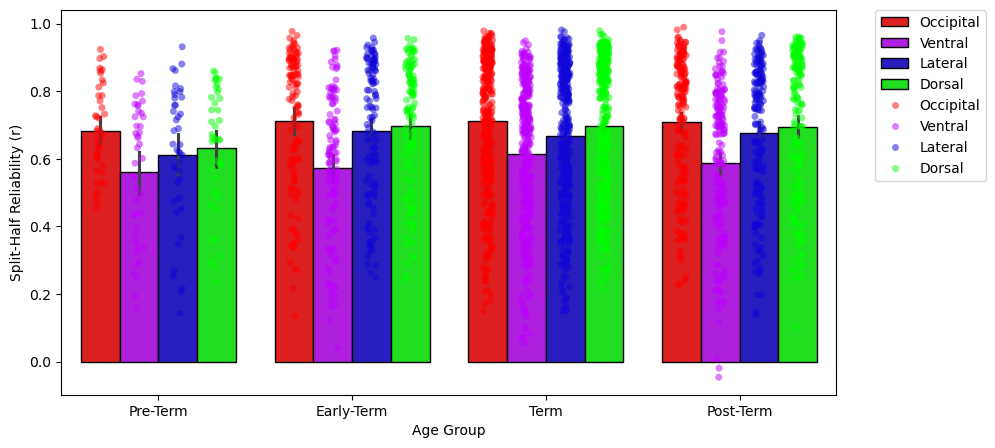

In [5]:


#set network and age_group as categorical
noise_df['network'] = pd.Categorical(noise_df['network'], categories=networks, ordered=True)
noise_df['age_group'] = pd.Categorical(noise_df['age_group'], categories=age_groups, ordered=True)

#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['sub'].isin(subs2analyze['participant_id'])]



#summarize data by network and age group
noise_df = noise_df.groupby(['sub', 'ses', 'network', 'age_group']).mean(numeric_only=True).reset_index()





#plot noise ceiling by network and age group as bar graphs
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='fc', data=noise_df,hue='network', palette=network_colors, edgecolor='k', errorbar=('ci',95))
#add individual data points
sns.stripplot(x='age_group', y='fc', data=noise_df, hue='network', dodge=True, palette=network_colors, edgecolor='k', alpha=0.5)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y axis label 
plt.ylabel('Split-Half Reliability (r)')

#set x axis label
plt.xlabel('Age Group')

<Axes: xlabel='age_group', ylabel='fc'>

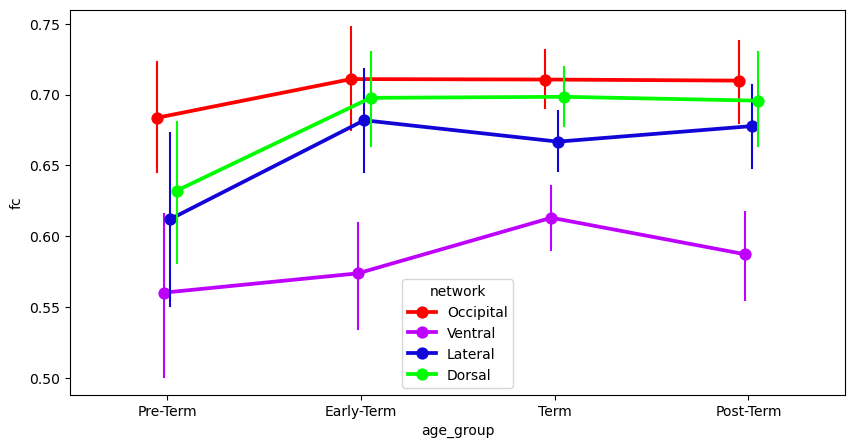

In [6]:
#plot noise ceiling as point_plot
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='fc', data=noise_df, hue='network', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

## Arealization analyses

In [14]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]





In [15]:
'''load and process adult data'''

adult_fc = pd.read_csv(f'{params.results_dir}/group_fc/adult_{atlas}_median_fc.csv', header = None).values
#set diagonal to nan
np.fill_diagonal(adult_fc, np.nan)

#convert to pandas dataframe and melt
adult_df = pd.DataFrame(adult_fc, index = all_rois, columns = all_rois)


#melt so that you have an roi1 and roi1 column
adult_df = adult_df.melt(var_name = 'roi2', value_name = 'fc', ignore_index = False).reset_index().rename(columns = {'index':'roi1'})
adult_df = adult_df.dropna()

#add network labels
adult_df['network1'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi1']]
adult_df['network2'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi2']]

#split roi into hemi and roi
adult_df['hemi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[0])
adult_df['roi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[1])

adult_df['hemi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[0])
adult_df['roi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[1])

#add roi_similarity, network_similarity, and hemi_similarity columns
adult_df['roi_similarity'] = ['same' if roi1 == roi2 else 'diff' for roi1, roi2 in zip(adult_df['roi1'], adult_df['roi2'])]
adult_df['network_similarity'] = ['same' if network1 == network2 else 'diff' for network1, network2 in zip(adult_df['network1'], adult_df['network2'])]
adult_df['hemi_similarity'] = ['same' if hemi1 == hemi2 else 'diff' for hemi1, hemi2 in zip(adult_df['hemi1'], adult_df['hemi2'])]

#extract only diff hemispheres
adult_df = adult_df[adult_df['hemi_similarity'] == 'diff']

#groupby roi1, roi2, roi_similarity,  network_similarity, roi_similarity_adj
adult_df = adult_df.groupby(['roi1', 'roi2', 'roi_similarity', 'network_similarity']).mean(numeric_only=True).reset_index()

#create column for  same, adjacent, and distant areas
#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
adult_df['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj1) | (adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj2),
                                                     'Adjacent', adult_df['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    adult_df['roi_similarity_adj'] = np.where(adult_df['roi1'] == adult_df['roi2'], 'Same\nArea', adult_df['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] != adult_df['roi2']) & (adult_df['roi_similarity_adj'] != 'Adjacent') & (adult_df['roi_similarity_adj'] != 'same'),
                                                     'Distal', adult_df['roi_similarity_adj'])



#### Compute Arealization overall

In [16]:
def create_mat(df,col = 'fc', roi_labels=all_rois):
    #create empty matrix to store infant data
    mat = np.zeros((len(roi_labels), len(roi_labels)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(roi_labels):
        for j, roi2 in enumerate(roi_labels):
            mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    corr_mat = np.tril(corr_mat)

    #set 0s to nans
    corr_mat[corr_mat == 0] = np.nan


    sns.heatmap(corr_mat, cmap= 'coolwarm', cbar =True, vmin=0, vmax=.8, xticklabels = False, yticklabels = False)
    #make bigger 
    plt.gcf().set_size_inches(12,12)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90, fontsize = 14)
    plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0, fontsize = 14)

  
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #make background white
    ax.set_facecolor('white')

    

    if file_name is not None:
        plt.savefig(f'{git_dir}/figures/{file_name}.png')    

    plt.show()
    plt.pause(.001)



In [17]:
#load adjacency file for rois
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#extract day 1 data
# extract infants that were scanned on day 1
curr_df = sub_df[sub_df['age'] <= 1]
curr_df_median = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2', 'roi_similarity', 'hemi_similarity']).median(numeric_only=True).reset_index()

#extract hemi_similarity == diff
curr_df_diff = curr_df_median[curr_df_median['hemi_similarity'] == 'diff']

#average by roi1 and roi2, roi_similairty
curr_df_diff = curr_df_diff.groupby(by=['roi1', 'roi2', 'roi_similarity']).mean(numeric_only=True).reset_index()

#extract fc matrix
fc_mat = create_mat(curr_df_diff, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


(24, 24)


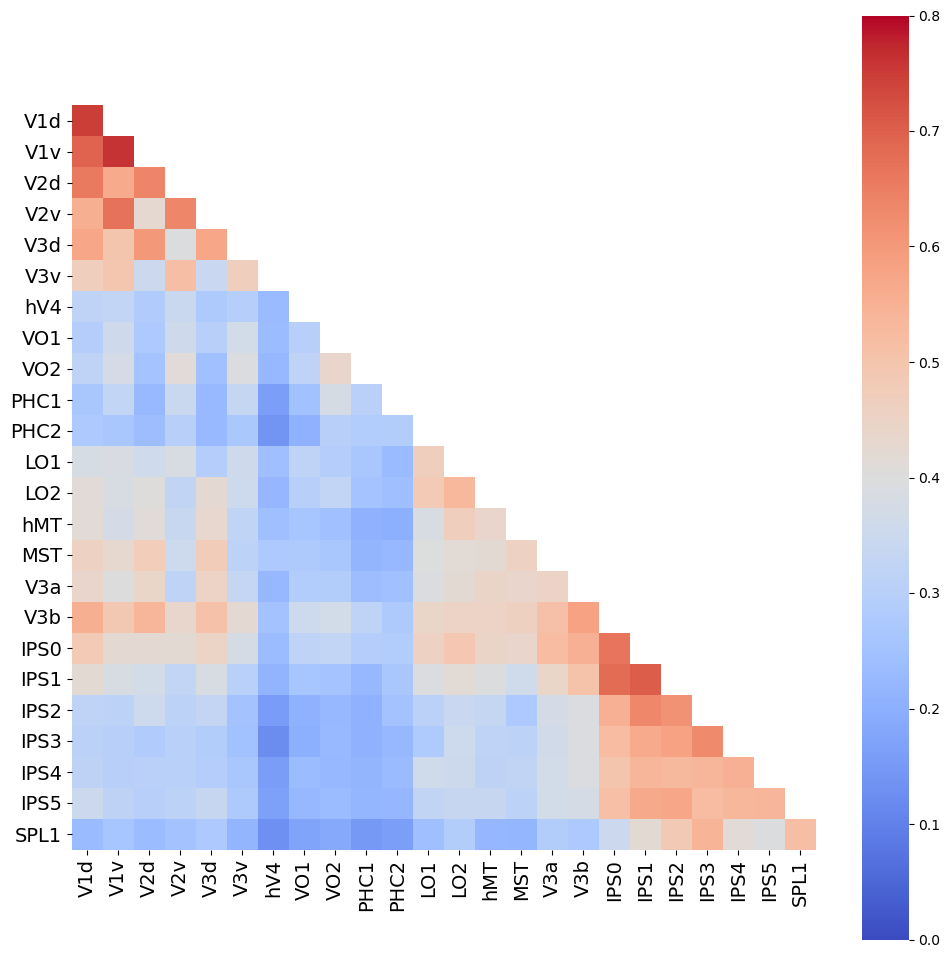

<Figure size 640x480 with 0 Axes>

In [95]:

#create heatmap
plot_fc_matrix(fc_mat_df, adj_rois['label'].to_list(), 'infant_day1_arealization')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1_arealization.png')


(24, 24)


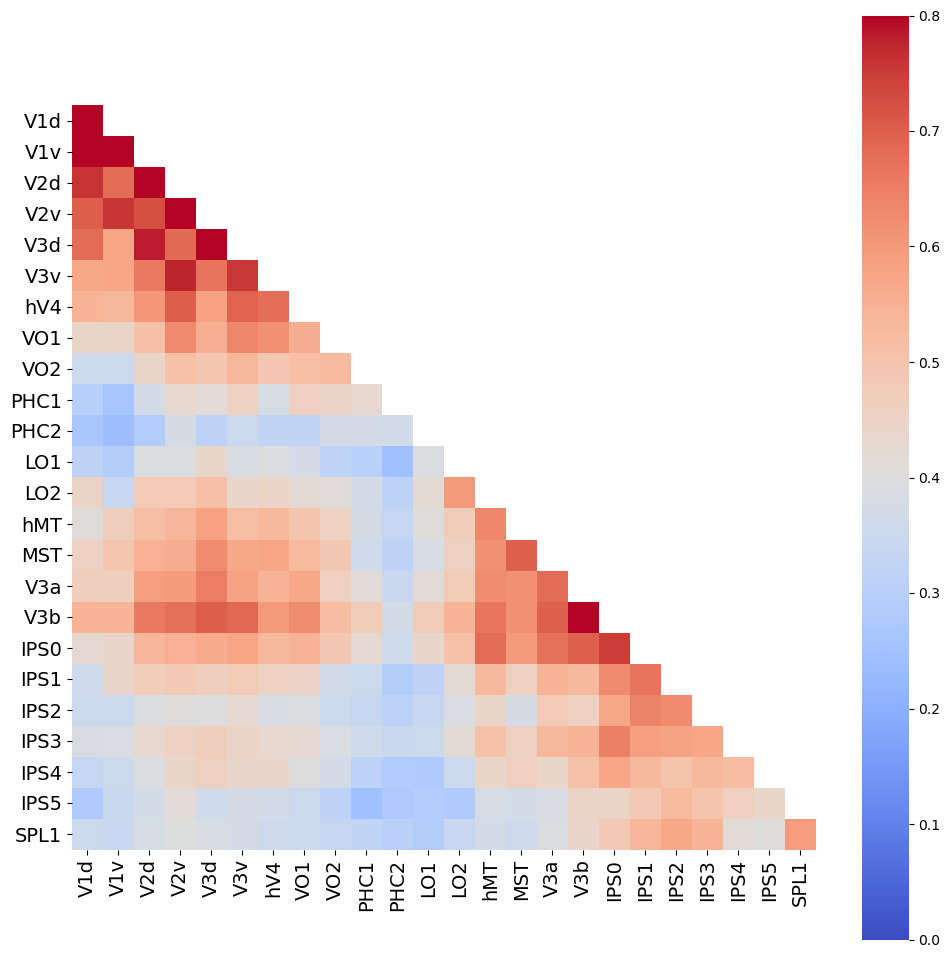

<Figure size 640x480 with 0 Axes>

In [96]:
#create adult heatmap
#extract fc matrix
adult_mat = create_mat(adult_df, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
adult_mat_df = pd.DataFrame(adult_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


#create heatmap
plot_fc_matrix(adult_mat_df, adj_rois['label'].to_list(), 'adult_arealization')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/adult_arealization.png')

#### Plot Arealization across types

In [20]:
#group by ROIs
df_roi_summary = sub_df.groupby(['sub', 'ses', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']

#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])


#### Plot as bars

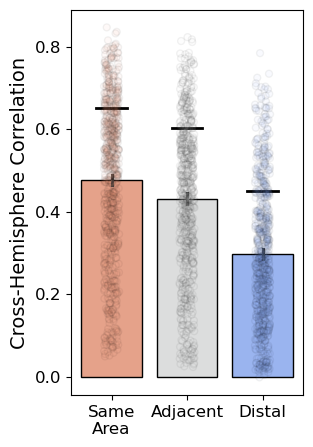

In [92]:
#group by roi_similarity_adj
df_areal_summary = df_roi_summary.groupby(['sub', 'ses', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

adult_df_areal_summary = adult_df.groupby(['roi_similarity_adj']).mean(numeric_only=True).reset_index()


comp_order = ['Same\nArea', 'Adjacent', 'Distal']

#make roi_network_similarity a categorical variable
df_areal_summary['roi_similarity_adj'] = pd.Categorical(df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
adult_df_areal_summary['roi_similarity_adj'] = pd.Categorical(adult_df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#reorder adult_df to match comp_order
adult_df_areal_summary = adult_df_areal_summary.sort_values(by='roi_similarity_adj')

#plot arealization by roi_network_similarity

sns.barplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, palette='coolwarm_r', edgecolor='k', errorbar=('ci',95))

#add individual data points with same colors as bar plot
sns.stripplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, marker = 'o',palette='coolwarm_r', edgecolor='k', linewidth=1,alpha=.05)

#add black line above each bar for adult data
for i, val in enumerate(adult_df_areal_summary['fc']):
    plt.plot([i-0.2, i+0.2], [val, val], color = 'k', linewidth = 2)


#change figure size
plt.gcf().set_size_inches(3,5)

#remove x axis label
plt.xlabel('')
#rename Y-axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize=14)

#set x-axis fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save figure
plt.savefig(f'{git_dir}/figures/arealization/neonate_barplot.png')

In [59]:
#run repeated measures ANOVA
import pingouin as pg

#run repeated measures ANOVA
aovrm = pg.rm_anova(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, effsize='np2')

print(aovrm)

#run pairwise comparisons
post_hocs = pg.pairwise_ttests(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, padjust='holm', effsize='cohen')
print(post_hocs)

               Source  ddof1  ddof2            F  p-unc       np2       eps
0  roi_similarity_adj      2   1260  2801.803926    0.0  0.816423  0.590584
             Contrast           A         B  Paired  Parametric          T  \
0  roi_similarity_adj  Same\nArea  Adjacent    True        True  36.410306   
1  roi_similarity_adj  Same\nArea    Distal    True        True  55.422319   
2  roi_similarity_adj    Adjacent    Distal    True        True  52.145127   

     dof alternative          p-unc         p-corr p-adjust        BF10  \
0  630.0   two-sided  4.145190e-157  4.145190e-157     holm  1.418e+153   
1  630.0   two-sided  1.953516e-244  5.860549e-244     holm  1.814e+240   
2  630.0   two-sided  9.694480e-231  1.938896e-230     holm  3.923e+226   

      cohen  
0  0.263263  
1  1.075996  
2  0.819105  


#### compute arealization as a function of areal distance

In [97]:
network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2'],['V1d', 'V2d','V3d'], ['', '','', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1'], ['', '','', 'LO1','LO2','hMT','MST']]
networks = ['Ventral', 'Occipital_D','Dorsal', 'Lateral']

#for each roi add number corresponding to its position in the network
df_roi_summary['network1'] = np.nan
df_roi_summary['network2'] = np.nan
df_roi_summary['roi_num1'] = np.nan
df_roi_summary['roi_num2'] = np.nan


for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        df_roi_summary['network1'] = np.where(df_roi_summary['roi1'] == roi, network, df_roi_summary['network1'])
        df_roi_summary['network2'] = np.where(df_roi_summary['roi2'] == roi, network, df_roi_summary['network2'])
        df_roi_summary['roi_num1'] = np.where(df_roi_summary['roi1'] == roi, i, df_roi_summary['roi_num1'])
        df_roi_summary['roi_num2'] = np.where(df_roi_summary['roi2'] == roi, i, df_roi_summary['roi_num2'])


#only keep rows where network1 and network2 are the same
df_network_summary = df_roi_summary[df_roi_summary['network1'] == df_roi_summary['network2']]

#add rows where network1 or network2 are dorsal and network2 or network1 are occipital_d using concat
df_network_summary = pd.concat([df_network_summary, df_roi_summary[(df_roi_summary['network1'] == 'Dorsal') & (df_roi_summary['network2'] == 'Occipital_D')]])
df_network_summary = pd.concat([df_network_summary, df_roi_summary[(df_roi_summary['network2'] == 'Dorsal') & (df_roi_summary['network1'] == 'Occipital_D')]])

#add rows where network1 or network2 are lateral and network2 or network1 are occipital_d
df_network_summary = pd.concat([df_network_summary, df_roi_summary[(df_roi_summary['network1'] == 'Lateral') & (df_roi_summary['network2'] == 'Occipital_D')]])
df_network_summary = pd.concat([df_network_summary, df_roi_summary[(df_roi_summary['network2'] == 'Lateral') & (df_roi_summary['network1'] == 'Occipital_D')]])

#add column with num difference between roi1 and roi2
df_network_summary['roi_dist'] = np.abs(df_network_summary['roi_num1'] - df_network_summary['roi_num2'])


#compute arealization distance for adult data
adult_df['network1'] = np.nan
adult_df['network2'] = np.nan

adult_df['roi_num1'] = np.nan
adult_df['roi_num2'] = np.nan

for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        adult_df['network1'] = np.where(adult_df['roi1'] == roi, network, adult_df['network1'])
        adult_df['network2'] = np.where(adult_df['roi2'] == roi, network, adult_df['network2'])
        adult_df['roi_num1'] = np.where(adult_df['roi1'] == roi, i, adult_df['roi_num1'])
        adult_df['roi_num2'] = np.where(adult_df['roi2'] == roi, i, adult_df['roi_num2'])

#only keep rows where network1 and network2 are the same
adult_df_network_summary = adult_df[adult_df['network1'] == adult_df['network2']]

#add rows where network1 or network2 are dorsal and network2 or network1 are occipital_d using concat
adult_df_network_summary = pd.concat([adult_df_network_summary, adult_df[(adult_df['network1'] == 'Dorsal') & (adult_df['network2'] == 'Occipital_D')]])
adult_df_network_summary = pd.concat([adult_df_network_summary, adult_df[(adult_df['network2'] == 'Dorsal') & (adult_df['network1'] == 'Occipital_D')]])

#add rows where network1 or network2 are lateral and network2 or network1 are occipital_d
adult_df_network_summary = pd.concat([adult_df_network_summary, adult_df[(adult_df['network1'] == 'Lateral') & (adult_df['network2'] == 'Occipital_D')]])
adult_df_network_summary = pd.concat([adult_df_network_summary, adult_df[(adult_df['network2'] == 'Lateral') & (adult_df['network1'] == 'Occipital_D')]])

#add column with num difference between roi1 and roi2
adult_df_network_summary['roi_dist'] = np.abs(adult_df_network_summary['roi_num1'] - adult_df_network_summary['roi_num2'])






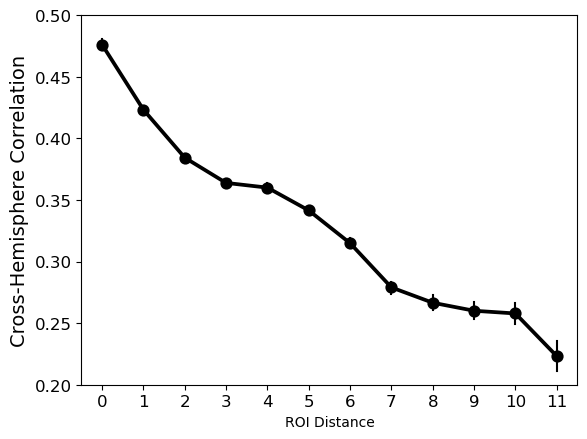

In [103]:
'''Overall arealization only'''

plt.figure()
#plot neonate data
sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

#plot adult data
#sns.pointplot(x='roi_dist', y='fc', data=adult_df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='r')


#set ylim 
plt.ylim([0.2, .5])

#set x axis label
plt.xlabel('ROI Distance')

plt.ylabel('Cross-Hemisphere\nCorrelation')

#make x axis labels integers
plt.xticks(np.arange(0, 12, 1), [str(i) for i in np.arange(0, 12, 1)])

plt.ylabel('Cross-Hemisphere Correlation', fontsize=14)

#set x-axis fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save figure
plt.savefig(f'{git_dir}/figures/arealization/neonate_areal_distance.png')

<Axes: xlabel='roi_dist', ylabel='fc'>

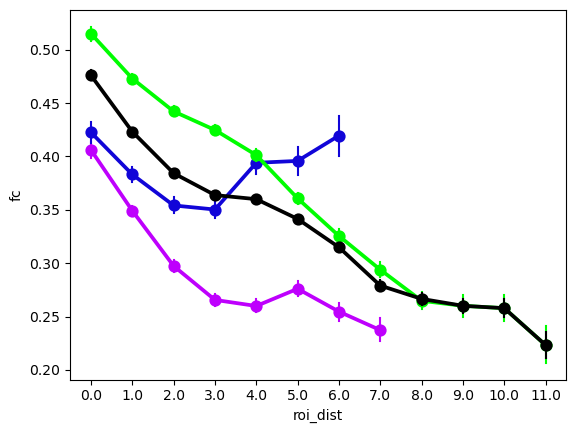

In [85]:
'''arealization with all rois'''
plt.figure()


network_colors = ['#be00fd', '#1105d8', '#00fd00']

#split by network_similarity and loop through each network
for network in ['Ventral',  'Lateral','Dorsal']:
    #extract data for network
    curr_df = df_network_summary[(df_network_summary['network1'] == network) | (df_network_summary['network2'] == network)]

    #remove data with occipital_d
    curr_df = curr_df[curr_df['network1'] != 'Occipital_D']
    
    #plot arealization by roi_dist as point plot
    sns.pointplot(x='roi_dist', y='fc', data=curr_df, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color=network_colors.pop(0))


sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

In [81]:
#group curr_df by roi1 roi2 and roi_dist
curr_df = curr_df.groupby(['roi1', 'roi2', 'roi_dist']).mean(numeric_only=True).reset_index()

#sort by roi1 and roi_dist
curr_df = curr_df.sort_values(by=['roi1', 'roi_dist'])

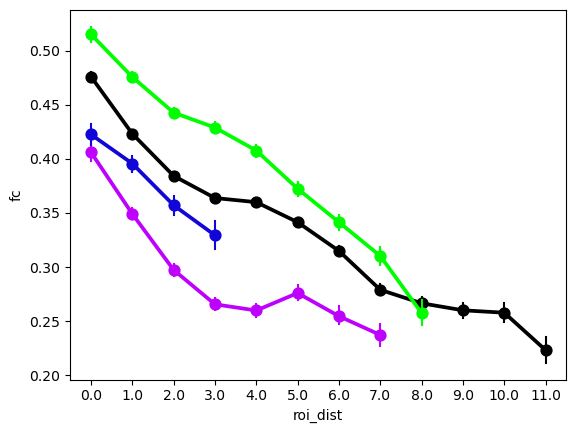

In [82]:
'''
Arealization with just pathways
'''
plt.figure()
#plot arealization by roi_dist as point plot in black
sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

network_colors = ['#be00fd', '#1105d8', '#00fd00']

#split by network_similarity and loop through each network
for network in ['Ventral', 'Lateral','Dorsal']:
    #extract data for network
    curr_df = df_network_summary[df_network_summary['network1'] == network]

    #remove data with occipital_d
    curr_df = curr_df[curr_df['network2'] != 'Occipital_D']
    
    #plot arealization by roi_dist as point plot


    
    sns.pointplot(x='roi_dist', y='fc', data=curr_df, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color=network_colors.pop(0))


#### Plot roi level analysis

Text(0.5, 0, '')

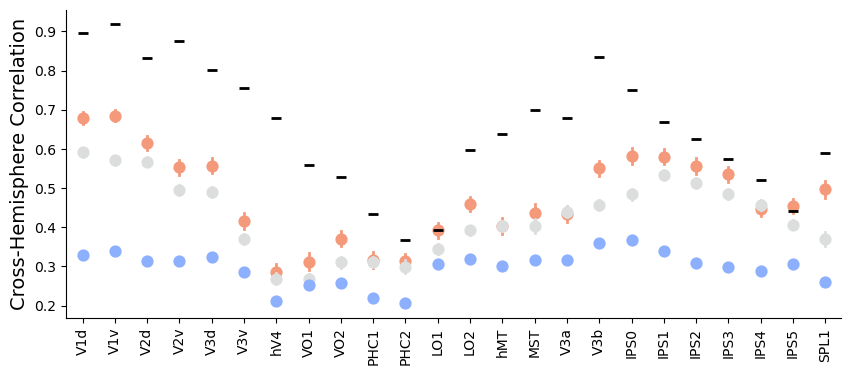

In [109]:
'''
Plot the value of same, adjacent, and distant areas for each ROI
'''

#set order for area distance
df_roi_summary['roi_similarity_adj'] = pd.Categorical(df_roi_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#set order for rois
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=adj_rois['label'], ordered=True)

#rename same\nare to same area


#extract same area data from adult
adult_df_same = adult_df[adult_df['roi_similarity_adj'] == 'Same\nArea']
#set categorical variables for adult_roi_summary
adult_df['roi1'] = pd.Categorical(adult_df['roi1'], categories=adj_rois['label'], ordered=True)

#Plot each ROI as a point plot, where x is roi1 and hue is roi_similarity_adj
sns.pointplot(x='roi1', y='fc', data=df_roi_summary, hue='roi_similarity_adj',palette = 'coolwarm_r', ci=95, dodge=False, markers='o', linestyles='', errwidth=2, capsize=0)

#plot adult data as black lines
sns.pointplot(x='roi1', y='fc', data=adult_df_same, ci=95, dodge=True, markers='_', linestyles='', errwidth=1.5, capsize=0, color='k')

#hide legend
plt.legend().remove()

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#### Compute arealization index as same-adjacent and correlate to adults

In [118]:

#group by roi1 and roi_similarity_adj
df_roi_index = df_roi_summary.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()
#remove rows with 
df_adult_roi = adult_df.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

#remove rows with distal
df_roi_index = df_roi_index[df_roi_index['roi_similarity_adj'] != 'Distal']
df_adult_roi = df_adult_roi[df_adult_roi['roi_similarity_adj'] != 'Distal']


#pivot table so that each roi is a row and each column is a roi_similarity_adj
df_roi_index = df_roi_index.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
df_adult_roi = df_adult_roi.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
#create new col for each with the difference between same and adjacent
df_roi_index['areal_ratio'] = df_roi_index['Same\nArea'] - df_roi_index['Adjacent']
df_adult_roi['areal_ratio'] = df_adult_roi['Same\nArea'] - df_adult_roi['Adjacent']

#correlate neonate and adult ratios
corr = stats.pearsonr(df_roi_index['areal_ratio'], df_adult_roi['areal_ratio'])

print(corr)





PearsonRResult(statistic=0.6872421312666056, pvalue=0.00020725989194650217)


In [61]:
roi_table = df_roi_summary.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

In [ ]:
sub_df = sub_df[sub_df['age'] <= 1]

adult_df = sub_df.groupby(['roi1', 'roi2','network1','network2','hemi_similarity','roi_similarity']).mean(numeric_only=True).reset_index()

#keep only where hemi_similarity == diff
adult_df = adult_df[adult_df['hemi_similarity'] == 'diff']



Text(0.5, 0, '')

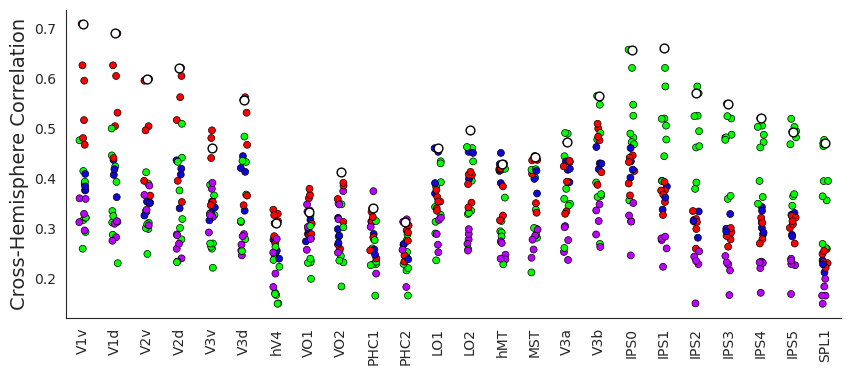

In [ ]:
''' plot at ROI level'''

network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
adult_df['roi1'] = pd.Categorical(adult_df['roi1'], categories=roi_labels['label'], ordered=True)
adult_df['network2'] = pd.Categorical(adult_df['network2'], categories=network_order, ordered=True)

df_roi_same = adult_df[adult_df['roi_similarity']=='same']



sns.scatterplot(data = df_roi_same, x = 'roi1', y = 'fc', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = adult_df, x = 'roi1', y = 'fc', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
#sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

##### Arealization as function of distance in maps
i.e., assign rois a distance value based on the hierarchy; maybe within pathway

#### Arealization as a function of age

In [9]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')



#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]




# group by hemi_simlarity, roi_similarity, network_similarity
age_df = sub_df.groupby(['sub', 'ses', 'age','age_group','hemi_similarity','roi_similarity','network_similarity', 'network1']).mean(numeric_only=True).reset_index()
#round all values to 4 decimal places
age_df = sub_df.round(4)


#extract only diff hemi_similarity
age_df = age_df[age_df['hemi_similarity'] == 'diff']
#extract only in same network similarity
age_df = age_df[age_df['network_similarity'] == 'same']

#pivot so that sub and network are indices and roi_similarity is columns
age_df = age_df.pivot_table(index = ['sub','ses','age_group','scan_age','birth_age','age','network1'], columns = 'roi_similarity', values = 'fc').reset_index()

#Create new column that is the difference between same and diff
age_df['arealization_index'] = age_df['same'] - age_df['diff']

#save 
age_df.to_csv(f'{git_dir}/results/infant_{atlas}_arealization_index.csv', index = False)

(-0.1, 0.25)

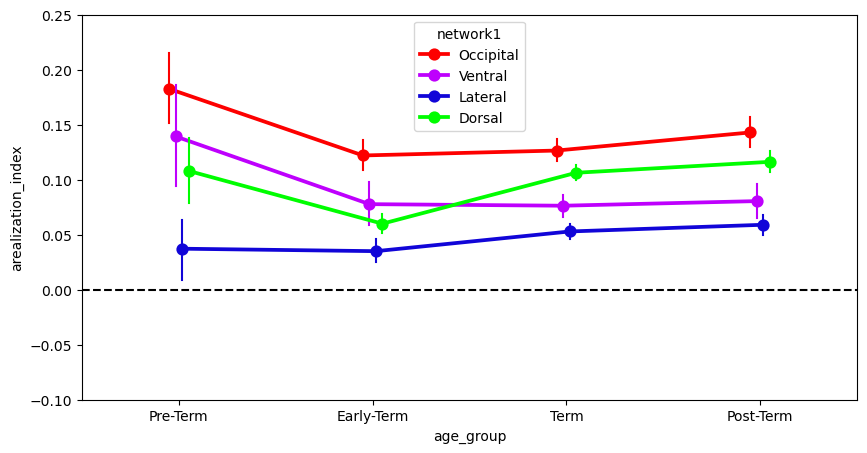

In [14]:
#make age_group categorical
age_df['age_group'] = pd.Categorical(age_df['age_group'], categories=age_groups, ordered=True)
#network categorical
age_df['network1'] = pd.Categorical(age_df['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='arealization_index', data=age_df, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

plt.ylim(-.1,.25)

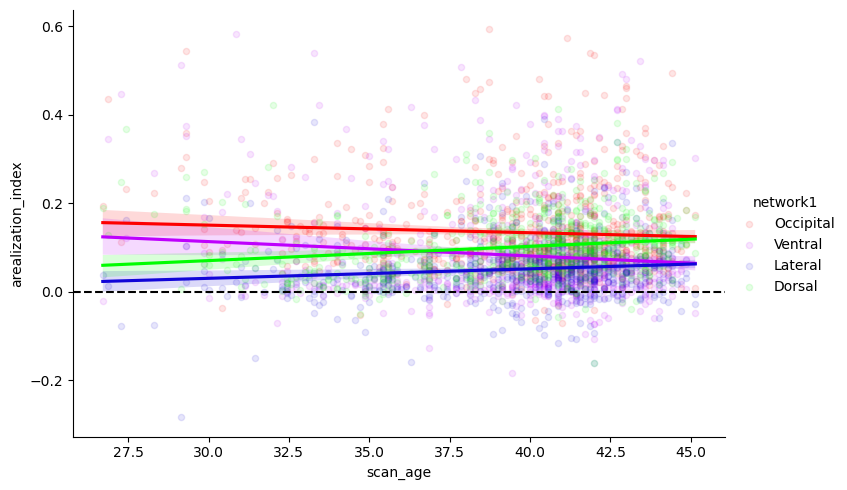

In [150]:
#lmplot of arealization index by scan_age
network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']

#set network order as categorical and level order
age_df['network1'] = pd.Categorical(age_df['network1'], categories=network_order, ordered=True)

sns.lmplot(data = age_df, x = 'scan_age', y = 'arealization_index', hue = 'network1', palette = network_colors, scatter_kws = {'s': 20,  'alpha':.1}, height = 5, aspect = 1.5)

#add dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')





#### Plot controlling for age, or gestation (scan_age)

In [152]:
#regress out age and save residuals in new column
age_df['arealization_age_resid'] = np.nan
age_df['arealization_gestation_resid'] = np.nan
for network in networks:
    #regress out age
    curr_data = age_df[age_df['network1'] == network]
    X = stats.zscore(curr_data['age'])
    y = stats.zscore(curr_data['arealization_index'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    age_df.loc[age_df['network1'] == network, 'arealization_age_resid'] = model.resid
    
    #regress out scan_age
    X = stats.zscore(curr_data['scan_age'])
    y = stats.zscore(curr_data['arealization_index'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    age_df.loc[age_df['network1'] == network, 'arealization_gestation_resid'] = model.resid

   
    

Text(38.726909143518526, 0.5, 'Arealization Index')

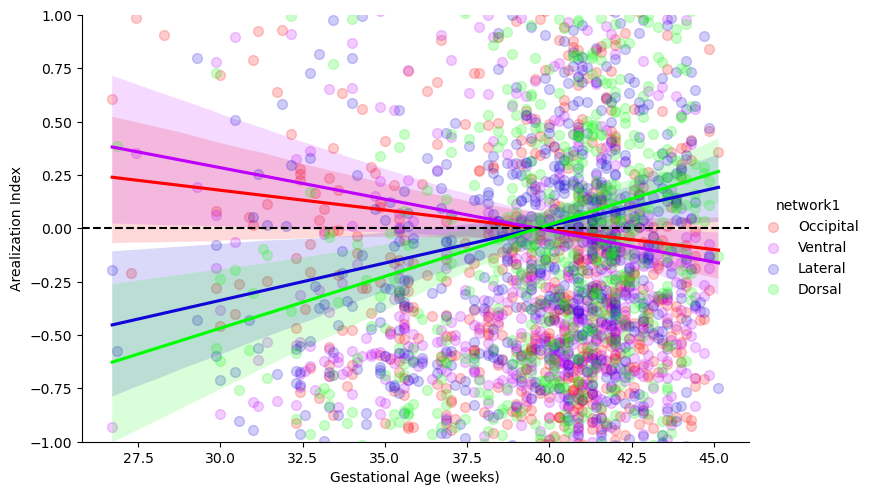

In [162]:
#make lmplots of residuals as a function of gestational age (scan_age), controlling for age since birth
sns.lmplot(data = age_df, x = 'scan_age', y = 'arealization_age_resid', hue = 'network1', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
#dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')

#set ylim
plt.ylim(-1,1)

# set x label to gestational age
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Arealization Index')

Text(38.726909143518526, 0.5, 'Arealization Index')

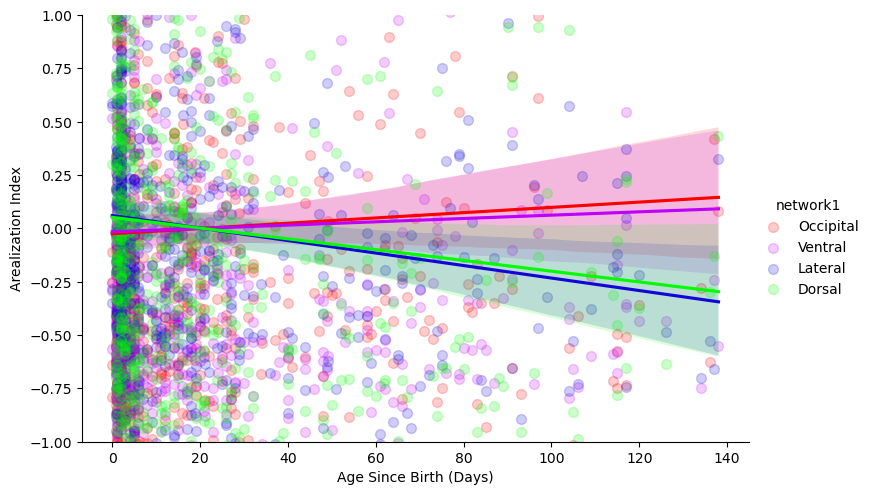

In [163]:
#plot residuals as a function of age since birth controlling for gestational age(scan_age)
sns.lmplot(data = age_df, x = 'age', y = 'arealization_gestation_resid', hue = 'network1', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
plt.ylim(-1,1)

#set X label to age since birth
plt.xlabel('Age Since Birth (Days)')
plt.ylabel('Arealization Index')